# Research Assistant

## Review

We've covered a few major LangGraph themes:

* Memory
* Human-in-the-loop
* Controllability

Now, we'll bring these ideas together to tackle one of AI's most popular applications: research automation.

Research is often laborious work offloaded to analysts. AI has considerable potential to assist with this.

However, research demands customization: raw LLM outputs are often poorly suited for real-world decision-making workflows.

Customized, AI-based [research and report generation](https://jxnl.co/writing/2024/06/05/predictions-for-the-future-of-rag/#reports-over-rag) workflows are a promising way to address this.

## Goal

Our goal is to build a lightweight, multi-agent system around chat models that customizes the research process.

`Source Selection`
* Users can choose any set of input sources for their research.
  
`Planning`
* Users provide a topic, and the system generates a team of AI analysts, each focusing on one sub-topic.
* `Human-in-the-loop` will be used to refine these sub-topics before research begins.
  
`LLM Utilization`
* Each analyst will conduct in-depth interviews with an expert AI using the selected sources.
* The interview will be a multi-turn conversation to extract detailed insights as shown in the [STORM](https://arxiv.org/abs/2402.14207) paper.
* These interviews will be captured in a using `sub-graphs` with their internal state.
   
`Research Process`
* Experts will gather information to answer analyst questions in `parallel`.
* And all interviews will be conducted simultaneously through `map-reduce`.

`Output Format`
* The gathered insights from each interview will be synthesized into a final report.
* We'll use customizable prompts for the report, allowing for a flexible output format.

![Screenshot 2024-08-26 at 7.26.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb164d61c93d48e604091_research-assistant1.png)

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_community langchain_core tavily-python wikipedia langchain_tavily langchain_groq

## **Setup**

In [2]:
import os, operator, warnings, getpass
from typing import List, TypedDict, Annotated
from langgraph.graph import MessagesState
from pydantic import BaseModel, Field
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from langchain_tavily import TavilySearch
from langchain_community.document_loaders import WikipediaLoader
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import Send
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, BaseMessage
from langchain_core.messages import get_buffer_string
from IPython.display import Image, display, Markdown
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq
from prompt import *

warnings.filterwarnings("ignore")

/usr/local/lib/python3.12/dist-packages/langchain_tavily/tavily_research.py:97: UserWarning: Field name "output_schema" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  class TavilyResearch(BaseTool):  # type: ignore[override, override]
/usr/local/lib/python3.12/dist-packages/langchain_tavily/tavily_research.py:97: UserWarning: Field name "stream" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  class TavilyResearch(BaseTool):  # type: ignore[override, override]


In [3]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")
_set_env("LANGSMITH_API_KEY")

OPENAI_API_KEY: ··········
TAVILY_API_KEY: ··········
LANGSMITH_API_KEY: ··········


In [4]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
llm.invoke("Hello, how are you?").content

"Hello! I'm just a program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?"

We'll use [LangSmith](https://docs.langchain.com/langsmith/home) for [tracing](https://docs.langchain.com/langsmith/observability-concepts).

In [5]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_PROJECT"] = "research_assistant"

## **Generate Analysts: Human-In-The-Loop**

Create analysts and review them using human-in-the-loop.

In [6]:
class Analysts(BaseModel):
    affiliation: str = Field(..., description="Primary affiliation of the analyst.")
    name: str = Field(..., description="Name of the analyst.")
    role: str = Field(..., description="Role of the analyst in the context of topic.")
    description: str = Field(..., description="Description of the analyst focus, concerns, and motives.")

    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analyst: List[Analysts] = Field(
        description="comprehensive list of analysts with their roles, descriptions, and affiliations."
        )

In [7]:
class GenerateAnalystState(TypedDict):
    topic: str
    max_analysts: int
    human_analyst_feedback: str
    analysts: List[Analysts]

In [8]:
def create_analyst(state: GenerateAnalystState) -> dict:
    """Create an analyst to generate a report."""
    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback = state.get("human_analyst_feedback", "")

    # Create a structured LLM
    structured_llm = llm.with_structured_output(Perspectives)

    # system prompt
    system_prompt = SystemMessage(
        content=ANALYST_INSTRUCTIONS.format(
            topic=topic,
            max_analysts=max_analysts,
            human_analyst_feedback=human_analyst_feedback,
        ))

    # human message
    human_message = HumanMessage(content="Create a set of analysts.")

    # create the analyst
    analysts = structured_llm.invoke([system_prompt, human_message])

    return {"analysts": analysts.analyst }

In [9]:
analysts = create_analyst({
    "topic": "AI Agents",
    "max_analysts": 2,
})

In [10]:
for analyst in analysts.get("analysts"):
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 100)

Name: Dr. Emily Carter
Affiliation: Tech Innovations Lab
Role: AI Ethics Analyst
Description: Dr. Carter focuses on the ethical implications of AI agents, exploring issues such as bias, accountability, and the societal impact of deploying AI technologies. Her work aims to ensure that AI systems are developed and implemented in a manner that is fair and just.
----------------------------------------------------------------------------------------------------
Name: Mr. James Liu
Affiliation: Future of Work Institute
Role: AI Workforce Integration Specialist
Description: Mr. Liu specializes in the integration of AI agents into the workforce, examining how these technologies can enhance productivity and collaboration. He is particularly interested in the future job landscape and the skills needed for humans to work alongside AI.
----------------------------------------------------------------------------------------------------


In [11]:
def human_feedback(state: GenerateAnalystState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateAnalystState):
    """ Return the next node to execute """

    # Check if human feedback is present
    if state.get("human_analyst_feedback", None):
        return "create_analyst"
    return END

In [12]:
# Add nodes and edges
analyst_builder = StateGraph(GenerateAnalystState)

# Add nodes
analyst_builder.add_node("create_analyst", create_analyst)
analyst_builder.add_node("human_feedback", human_feedback)

# Add edges
analyst_builder.add_edge(START, "create_analyst")
analyst_builder.add_edge("create_analyst", "human_feedback")
analyst_builder.add_conditional_edges("human_feedback", should_continue, ["create_analyst", END])

# Compile graph
memory = MemorySaver()
analyst_graph = analyst_builder.compile(checkpointer=memory, interrupt_before=["human_feedback"])

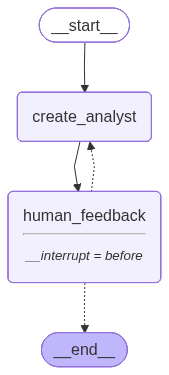

In [13]:
# View
display(Image(analyst_graph.get_graph(xray=1).draw_mermaid_png()))
# analyst_graph

### **Test the Graph**

In [14]:
# Input
max_analysts = 3
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

input_state = { "topic": topic, "max_analysts": max_analysts }

# Run the graph until the first interruption
for event in analyst_graph.stream(input_state, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 100)

Name: Dr. Emily Carter
Affiliation: Tech Innovations Inc.
Role: AI Framework Specialist
Description: Dr. Carter focuses on the technical advantages of LangGraph, analyzing its architecture and performance metrics compared to other frameworks. She is particularly interested in how LangGraph can enhance the efficiency of AI agents in real-world applications.
----------------------------------------------------------------------------------------------------
Name: Mr. James Liu
Affiliation: Future of Work Institute
Role: Workplace Integration Analyst
Description: Mr. Liu examines the implications of adopting LangGraph in workplace settings. His research emphasizes the benefits of improved collaboration and productivity among teams using AI agents powered by LangGraph.
----------------------------------------------------------------------------------------------------
Name: Ms. Sarah Thompson
Affiliation: Data-Driven Insights LLC
Role: Data Analytics Expert
Description: Ms. Thompson invest

In [15]:
# Get state and look at next node
current_state = analyst_graph.get_state(thread)
current_state.next

('human_feedback',)

In [16]:
# Continue the graph execution to end
for event in analyst_graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
human_feedback


In [17]:
# If we are satisfied, then we simply supply no feedback
further_feedback = None
analyst_graph.update_state(
    thread,
    { "human_analyst_feedback": further_feedback}, as_node="human_feedback"
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0e8aa5-e986-686b-8003-b3bdd926e7b5'}}

In [18]:
# Continue the graph execution to end
for event in analyst_graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [19]:
final_state = analyst_graph.get_state(thread)
analysts = final_state.values.get("analysts")

In [20]:
final_state.next

()

In [21]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50)

Name: Dr. Emily Carter
Affiliation: Tech Innovations Inc.
Role: AI Framework Specialist
Description: Dr. Carter focuses on the technical advantages of LangGraph, analyzing its architecture and performance metrics compared to other frameworks. She is particularly interested in how LangGraph can enhance the efficiency of AI agents in real-world applications.
--------------------------------------------------
Name: Mr. James Liu
Affiliation: Future of Work Institute
Role: Workplace Integration Analyst
Description: Mr. Liu examines the implications of adopting LangGraph in workplace settings. His research emphasizes the benefits of improved collaboration and productivity among teams using AI agents powered by LangGraph.
--------------------------------------------------
Name: Ms. Sarah Thompson
Affiliation: Data-Driven Insights LLC
Role: Data Analytics Expert
Description: Ms. Thompson investigates the data management capabilities of LangGraph, focusing on how it can streamline data process

## **Conduct Interview**

### **Generate Question**

- **The analyst will ask questions to the expert.**

In [22]:
class InterviewState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]    # Messages
    max_num_turns: int                                      # Number turns of conversation
    context: Annotated[List[str], operator.add]                  # Source docs
    analyst: Analysts                                       # Analyst asking questions
    interview: str                                          # Interview transcript
    sections: str                                           # Final key we duplicate in outer state for Send() API

    search_query: Annotated[List[str], operator.add]

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [23]:
def generate_question(state: InterviewState) -> dict:
    """ Generate question for analyst. """

    analyst = state['analyst']
    messages = state['messages']

    # generate question
    system_message = SystemMessage(content=QUESTION_INSTRUCTIONS.format(goals=analyst.persona))
    question = llm.invoke([system_message] + messages)

    # write message to state
    return { "messages": [question] }

In [ ]:
# in above node change "analyst.persona -> analyst['persona']" for testing below analyst persona
analyst_persona = {
    "persona":
    f"Name: {analyst.name}, \nRole: {analyst.role}, \nDescription: {analyst.description} \nAffiliation: {analyst.affiliation}"
    }
analyst_persona['persona']

'Name: Dr. Sarah Thompson, \nRole: Ethics and Compliance Analyst, \nDescription: Dr. Thompson investigates the ethical implications of using LangGraph as an agent framework. She is concerned with data privacy, bias in AI decision-making, and the regulatory landscape surrounding AI technologies. \nAffiliation: AI Ethics Consortium'

In [ ]:
question = generate_question({
    "analyst": analyst_persona,
    "messages": [],
})

In [ ]:
question['messages'][0].content

'Hello Dr. Thompson, my name is Alex Carter, and I’m an analyst focused on understanding the ethical implications of emerging technologies. I’m particularly interested in your work with LangGraph and the various challenges it presents. \n\nTo start, could you share some specific examples of how data privacy concerns manifest when using LangGraph as an agent framework? What are some surprising aspects of these concerns that you’ve encountered in your research?'

## **Generate Answer: Parallelization**
The expert will gather information from multiple sources in parallel to answer questions.

For example, we can use:

- Specific web sites e.g., via WebBaseLoader
- Indexed documents e.g., via [RAG](https://docs.langchain.com/oss/python/langchain/retrieval)
- Web search
- Wikipedia search

You can try different web search tools, like [Tavily](https://www.tavily.com/).

In [24]:
tavily_search = TavilySearch(max_results=3)

Now, we create nodes to search the web and wikipedia.

We'll also create a node to answer analyst questions.

Finally, we'll create nodes to save the full interview and to write a summary ("section") of the interview.

In [25]:
def web_search(state: InterviewState) -> dict:
    """ Retrieve docs from web search """

    message = state['messages']

    # search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke(
        [SEARCH_INSTRUCTIONS] + message
    )

    # search
    data = tavily_search.invoke({"query": search_query.search_query})
    search_docs = data.get("results", data)

    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    # Write to state
    return { "context": [formatted_search_docs], "search_query": [search_query] }

In [ ]:
web_search_result = web_search({"messages": question["messages"]})

In [ ]:
Markdown(web_search_result['search_query'][0].search_query)

data privacy concerns LangGraph agent framework examples ethical implications

In [ ]:
Markdown(web_search_result['context'][0])

<Document href="https://youssefh.substack.com/p/building-agents-with-langgraph-course-92e"/>
# Building Agents with LangGraph Course #7: Building a Multi-Agent System LangGraph. Welcome to the seventh part of our ongoing series“**Building Agents with LangGraph**” course! In this tutorial, we will build a multi-agent system that collaborates to write an essay. This article is the **Seventh Article** in the ongoing series of **Building LLM Agents with LangGraph**:. Building Essay Writer Agent (**You are here!**). This series is designed to take readers from foundational knowledge to advanced practices in building LLM agents with LangGraph. Each article delves into essential components, such as constructing simple ReAct agents from scratch, leveraging LangGraph’s building units, utilizing agentic search tools, implementing persistence and streaming capabilities, integrating human-in-the-loop interactions, and culminating in the creation of a fully functional essay-writing agent. The state is the backbone of our agent, defining the structure of data that gets passed between nodes. For our essay writer, the state needs to track several pieces of information: the initial task, the plan, the research content, the draft, critiques, and the number of revisions.
</Document>

---

<Document href="https://link.springer.com/10.1007/978-981-95-2909-4_17"/>
# Ethical Considerations in AI Agents. This chapter examines the ethical dimensions of AI agents, with particular focus on autonomous systems capable of independent decision-making in real-world environments. The chapter distinguishes between standard AI agents and autonomous systems, exploring their components including perception, decision-making, and action mechanisms. The chapter also covers practical frameworks for implementing AI agents using modern tools like LangChain, LangGraph, and Hugging Face, while emphasizing the importance of ethical design principles. Patiency is not a virtue: AI and the design of ethical systems. *Ethics and Information Technology,* *20*(1), 15–26. *Nature Machine Intelligence,* *1*(9), 389–399. *Nature Machine Intelligence,* *1*(11), 501–507. Machine ethics: The design and governance of ethical AI and autonomous systems. The global landscape of AI ethics guidelines*.* *Nature Machine Intelligence*. *Nature Machine Intelligence,* *1*(5), 206–215. What is reproducibility in artificial intelligence and machine learning research? *Machine learning and artificial intelligence research for patient benefit: 20 critical questions on transparency, replicability, ethics, and effectiveness*. Ethical Considerations in AI Agents.
</Document>

---

<Document href="https://www.reddit.com/r/LangChain/comments/1i1srqg/langgraph_how_to_prevent_an_agent_from_leaking/"/>
To address the problem of detecting whether an AI agent leaks specific information, such as the refund condition being about bad weather, we propose a multi-
</Document>

In [26]:
def search_wikipedia(state: InterviewState) -> dict:
    """ Retrieve docs from web search """

    message = state['messages']

    # search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke(
        [SEARCH_INSTRUCTIONS] + message
    )

    # search
    search_docs = WikipediaLoader(query=search_query.search_query, load_max_docs=2).load()

    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    # Write to state
    return { "context": [formatted_search_docs], "search_query": [search_query] }

In [ ]:
search_wikipedia_result = search_wikipedia({
    "messages": question["messages"]
})

In [ ]:
Markdown(search_wikipedia_result['search_query'][0].search_query)

data privacy concerns LangGraph agent framework examples ethical implications

In [ ]:
Markdown(search_wikipedia_result['context'][0])

<Document source="https://en.wikipedia.org/wiki/Big_data" page=""/>
Big data primarily refers to data sets that are too large or complex to be dealt with by traditional data-processing software. Data with many entries (rows) offer greater statistical power, while data with higher complexity (more attributes or columns) may lead to a higher false discovery rate.
Big data analysis challenges include capturing data, data storage, data analysis, search, sharing, transfer, visualization, querying, updating, information privacy, and data source. Big data was originally associated with three key concepts: volume, variety, and velocity. The analysis of big data that have only volume velocity and variety can pose challenges in sampling. A fourth concept, veracity, that refers to the level of reliability of data was thus added. Without sufficient investment in expertise for big data veracity, the volume and variety of data can produce costs and risks that exceed an organization's capacity to create and capture value from big data.
Current usage of the term big data tends to refer to the use of predictive analytics, user behavior analytics, or certain other advanced data analytics methods that extract value from big data, and seldom to a particular size of data set. "There is little doubt that the quantities of data now available are indeed large, but that's not the most relevant characteristic of this new data ecosystem."
Analysis of data sets can find new correlations to "spot business trends, prevent diseases, combat crime and so on". Scientists, business executives, medical practitioners, advertising and governments alike regularly meet difficulties with large data-sets in areas including Internet searches, fintech, healthcare analytics, geographic information systems, urban informatics, and business informatics. Scientists encounter limitations in e-Science work, including meteorology, genomics, connectomics, complex physics simulations, biology, and environmental research.
The size and number of available data sets have grown rapidly as data is collected by devices such as mobile devices, cheap and numerous information-sensing Internet of things devices, aerial (remote sensing) equipment, software logs, cameras, microphones, radio-frequency identification (RFID) readers and wireless sensor networks. The world's technological per-capita capacity to store information has roughly doubled every 40 months since the 1980s; as of 2012, every day 2.5 exabytes (2.17×260 bytes) of data are generated. Based on an IDC report prediction, the global data volume was predicted to grow exponentially from 4.4 zettabytes to 44 zettabytes between 2013 and 2020. By 2025, IDC predicts there will be 163 zettabytes of data. According to IDC, global spending on big data and business analytics (BDA) solutions is estimated to reach $215.7 billion in 2021. Statista reported that the global big data market is forecasted to grow to $103 billion by 2027. In 2011 McKinsey & Company reported, if US healthcare were to use big data creatively and effectively to drive efficiency and quality, the sector could create more than $300 billion in value every year. In the developed economies of Europe, government administrators could save more than €100 billion ($149 billion) in operational efficiency improvements alone by using big data. And users of services enabled by personal-location data could capture $600 billion in consumer surplus. One question for large enterprises is determining who should own big-data initiatives that affect the entire organization.
Relational database management systems and desktop statistical software packages used to visualize data often have difficulty processing and analyzing big data. The processing and analysis of big data may require "massively parallel software running on tens, hundreds, or even thousands of servers". What qualifies as "big data" varies depending on the capabilities of those analyzing it and their tools. Furthermore, expanding capabilities make big data a moving target. "For some organi
</Document>

---

<Document source="https://en.wikipedia.org/wiki/Applications_of_artificial_intelligence" page=""/>
Artificial intelligence is the capability of computational systems to perform tasks typically associated with human intelligence, such as learning, reasoning, problem-solving, perception, and decision-making. Artificial intelligence has been used in applications throughout industry and academia. Within the field of Artificial Intelligence, there are multiple subfields. The subfield of Machine learning has been used for various scientific and commercial purposes including language translation, image recognition, decision-making, credit scoring, and e-commerce. In recent years, there have been massive advancements in the field of generative artificial intelligence, which uses generative models to produce text, images, videos or other forms of data. This article describes applications of AI in different sectors.


== Agriculture ==

In agriculture, AI has been proposed as a way for farmers to identify areas that need irrigation, fertilization, or pesticide treatments to increase yields, thereby improving efficiency. AI has been used to attempt to classify livestock pig call emotions, automate greenhouses, detect diseases and pests, and optimize irrigation.


== Architecture and design ==


== Business ==

A 2023 study found that generative AI increased productivity by 15% in contact centers. Another 2023 study found it increased productivity by up to 40% in writing tasks. An August 2025 review by MIT found that of surveyed companies, 95% did not report any improvement in revenue from the use of AI. A September 2025 article by the Harvard Business Review describes how increased use of AI does not automatically lead to increases in revenue or actual productivity. Referring to "AI generated work content that masquerades as good work, but lacks the substance to meaningfully advance a given task" the article coins the term workslop. Per studies done in collaboration with the Stanford Social Media Lab, workslop does not improve productivity and undermines trust and collaboration among colleagues.


== Computer science ==


=== Programming assistance ===


==== AI-assisted software development ====
AI can be used for real-time code completion, chat, and automated test generation. These tools are typically integrated with editors and IDEs as plugins. AI-assisted software development systems differ in functionality, quality, speed, and approach to privacy. Creating software primarily via AI is known as "vibe coding". Code created or suggested by AI can be incorrect or inefficient. The use of AI-assisted coding can potentially speed-up software development, but can also slow-down the process by creating more work when debugging and testing. The rush to prematurely adopt AI technology can also incur additional technical debt. AI also requires additional consideration and careful review for cybersecurity, since AI coding software is trained on a wide range of code of inconsistent quality and often replicates poor practices.


==== Neural network design ====

AI can be used to create other AIs. For example, around November 2017, Google's AutoML project to evolve new neural net topologies created NASNet, a system optimized for ImageNet and POCO F1. NASNet's performance exceeded all previously published performance on ImageNet.


==== Quantum computing ====

Research and development of quantum computers has been performed with machine learning algorithms. For example, there is a prototype, photonic, quantum memristive device for neuromorphic computers (NC)/artificial neural networks and NC-using quantum materials with some variety of potential neuromorphic computing-related applications. The use of quantum machine learning  for quantum simulators has been proposed for solving physics and chemistry problems.


=== Historical contributions ===
AI researchers have created many tools to solve the most difficult problems in computer science. Many of their inventions have been adopted by mainstream computer science and are no longer considered AI. Al
</Document>

In [27]:
def generate_answer(state: InterviewState) -> dict:
    """ Generate answer for analyst. """

    analyst = state['analyst']
    messages = state['messages']
    context = state['context']

    # generate question
    system_message = SystemMessage(content=ANSWER_INSTRUCTIONS.format(goals=analyst.persona, context=context))
    answer = llm.invoke([system_message] + messages)

    # Name the message as coming from the expert
    answer.name = "expert"

    # write message to state
    return { "messages": [answer] }

In [ ]:
answer = generate_answer({
    "analyst": analyst_persona,
    "messages": question["messages"],
    "context": web_search_result["context"][0]
})

In [ ]:
answer["messages"][0].name

'expert'

In [ ]:
Markdown(answer['messages'][0].content)

Data privacy concerns in the context of using LangGraph as an agent framework primarily revolve around how data is collected, processed, and shared among agents. For instance, when building a multi-agent system, such as the essay-writing agent discussed in the course, the state of the agent must track various pieces of information, including the initial task, research content, and critiques. This data can potentially include sensitive information if not handled properly.

One surprising aspect of these concerns is the potential for unintentional data leakage. For example, if an agent is designed to collaborate and share information, there is a risk that it might inadvertently expose sensitive data, such as user inputs or specific conditions related to the task, if not adequately controlled. This highlights the importance of implementing robust data governance and privacy measures within the framework to prevent such leaks [1].

Moreover, the ethical design principles emphasized in the literature suggest that developers must be vigilant about the implications of autonomous decision-making by AI agents. This includes ensuring that the data used for training and operation does not perpetuate biases or violate privacy norms [2]. The regulatory landscape surrounding AI technologies is also evolving, which adds another layer of complexity to ensuring compliance with data protection laws while using frameworks like LangGraph.

In summary, the interplay between data privacy, ethical design, and regulatory compliance is critical when utilizing LangGraph for building AI agents, and it requires ongoing attention to mitigate risks effectively.

Sources:
[1] https://youssefh.substack.com/p/building-agents-with-langgraph-course-92e
[2] https://link.springer.com/10.1007/978-981-95-2909-4_17

In [28]:
def save_interview(state: InterviewState) -> dict:
    """ Save interview transcript to state """

    # Get messages
    messages = state['messages']

    # Convert interview transcript to string
    interview = get_buffer_string(messages)

    # Save the interview key to state
    return { "interview": interview }

In [ ]:
interview = save_interview({
    "messages": question["messages"]
})
Markdown(interview['interview'])

AI: Hello Dr. Thompson, my name is Alex Carter, and I’m an analyst focused on understanding the ethical implications of emerging technologies. I’m particularly interested in your work with LangGraph and the various challenges it presents. 

To start, could you share some specific examples of how data privacy concerns manifest when using LangGraph as an agent framework? What are some surprising aspects of these concerns that you’ve encountered in your research?

In [ ]:
[m for m in question['messages'] if isinstance(m, AIMessage)]

[AIMessage(content='Hello Dr. Thompson, my name is Alex Carter, and I’m an analyst focused on understanding the ethical implications of emerging technologies. I’m particularly interested in your work with LangGraph and the various challenges it presents. \n\nTo start, could you share some specific examples of how data privacy concerns manifest when using LangGraph as an agent framework? What are some surprising aspects of these concerns that you’ve encountered in your research?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 84, 'prompt_tokens': 232, 'total_tokens': 316, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_3683ee3deb', 'id': 'chatcmpl-Ctuc8RpdrD0bVt5Oi9W1kzEf2OIia', 'service_tier'

In [29]:
def route_messages(state: InterviewState, name: str = "expert") -> dict:
    """ Route between question and answer """

    # Get messages
    messages = state['messages']
    max_num_turns = state.get('max_num_turns', 2)

    # Check the number of expert answers
    num_responses = len(
        [
            m for m in messages if isinstance(m, AIMessage) and m.name == name
        ]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return "save_interview"

    # This router is run after each question - answer pair
    # Get the last question asked to check if it signals the end of discussion
    last_message = messages[-2]

    if "Thank you so much for your help" in last_message.content:
        return 'save_interview'
    return "ask_question"

In [30]:
def write_section(state: InterviewState):
    """ Node to answer a question """

    # Get state
    interview = state['interview']
    context = state['context']
    analyst = state['analyst']

    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_prompt = SystemMessage(content=SECTION_WRITER_INSTRUCTIONS.format(
        focus=analyst.description
    ))
    human_message = HumanMessage(content=f"Use this source to write your section: {context}")
    sections = llm.invoke(
        [system_prompt] + [human_message]
    )

    # Write to state
    return { "sections": [sections.content] }

In [ ]:
section = write_section({
    "interview": interview['interview'],
    "context": search_wikipedia_result['context'][0],
    "analyst": analyst
})

In [ ]:
Markdown(section['sections'][0])

## Ethical Implications of LangGraph: Navigating Data Privacy and AI Bias

### Summary
The rapid evolution of artificial intelligence (AI) technologies, particularly in the context of big data, raises significant ethical concerns regarding data privacy, bias in decision-making, and the regulatory landscape. Big data, defined as data sets too large or complex for traditional processing methods, presents unique challenges in capturing, storing, and analyzing information while ensuring privacy and reliability. The integration of AI into big data analytics has the potential to uncover valuable insights, but it also risks amplifying existing biases and ethical dilemmas. 

Recent insights reveal that while AI can enhance productivity across various sectors, including agriculture and business, it can also lead to the phenomenon of "workslop," where AI-generated content lacks substance and undermines trust among users [1][2]. This raises questions about the accountability of AI systems and the ethical implications of their deployment. The concept of veracity, which refers to the reliability of data, is crucial in this context. Without proper investment in ensuring data quality, organizations may face costs and risks that outweigh the benefits of big data initiatives [1].

Moreover, the sheer volume of data generated daily—estimated at 2.5 exabytes—highlights the urgency for robust regulatory frameworks to govern data usage and protect individual privacy [1]. As AI technologies become more integrated into decision-making processes, the potential for bias in AI algorithms poses a significant ethical challenge. The need for transparency and fairness in AI systems is paramount, as biased outcomes can have far-reaching consequences in areas such as healthcare, finance, and law enforcement [2].

The intersection of big data and AI necessitates a comprehensive approach to ethics, emphasizing the importance of responsible data management and algorithmic accountability. As organizations navigate this complex landscape, they must prioritize ethical considerations to foster trust and ensure that AI technologies serve the greater good.

### Sources
[1] https://en.wikipedia.org/wiki/Big_data  
[2] https://en.wikipedia.org/wiki/Applications_of_artificial_intelligence  

In [31]:
# define graph
interview_builder = StateGraph(InterviewState)

# add graph nodes
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("web_search", web_search)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("generate_answer", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# add graph edges
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "web_search")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("web_search", "generate_answer")
interview_builder.add_edge("search_wikipedia", "generate_answer")

interview_builder.add_conditional_edges(
    "generate_answer", route_messages, ["ask_question", "save_interview"]
)

interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Checpointer
memory = MemorySaver()

# compile graph
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interview")

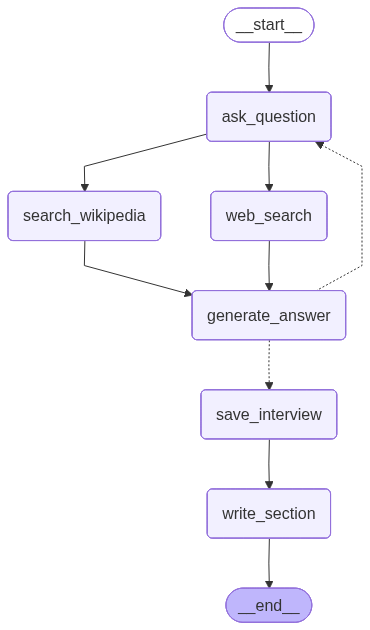

In [32]:
# View
display(Image(interview_graph.get_graph(xray=1).draw_mermaid_png()))
# interview_graph

In [ ]:
analysts[0]

Analysts(affiliation='Tech Innovations Inc.', name='Dr. Emily Carter', role='AI Framework Specialist', description='Dr. Carter focuses on the technical advantages of LangGraph, analyzing its architecture and performance metrics compared to other frameworks. She is particularly interested in how LangGraph can enhance the efficiency of AI agents in real-world applications.')

In [ ]:
topic = "The benefits of adopting LangGraph as an agent framework"
messages = [HumanMessage(content=f"So you said you were writing an article on {topic}?")]

thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, thread)

In [ ]:
interview.keys()

dict_keys(['messages', 'max_num_turns', 'context', 'analyst', 'interview', 'sections', 'search_query'])

In [ ]:
Markdown(interview['sections'][0])

## Unleashing the Power of LangGraph: A New Era for AI Agents

### Summary
LangGraph has emerged as a transformative framework for developing AI agents, offering significant technical advantages over traditional systems. This innovative platform allows developers to create complex, stateful applications that leverage large language models (LLMs) effectively. The architecture of LangGraph is designed to facilitate dynamic workflows, enabling seamless integration with existing tools and APIs. Notably, LangGraph's graph-based orchestration and persistent state management capabilities set it apart from other frameworks, making it particularly well-suited for advanced applications that require multi-agent coordination and decision-making.

One of the most compelling insights from recent analyses is the rapid adoption of LangGraph by major companies like LinkedIn and Uber, which underscores its practical utility in real-world applications. The framework's flexibility allows developers to choose from various features as building blocks, tailoring their agents to specific needs without unnecessary complexity. For instance, the ability to implement human-in-the-loop scenarios is as simple as invoking an `interrupt()` function, showcasing LangGraph's user-friendly design.

Moreover, LangGraph's integration with observability tools like Maxim AI enhances its reliability in production environments. This combination provides comprehensive visibility into agent performance, enabling teams to identify issues quickly and optimize workflows effectively. The framework's ability to handle complex, stateful interactions while maintaining context over long conversations is a game-changer for AI applications, particularly in sectors requiring nuanced decision-making.

The rapid evolution of LangGraph, alongside its increasing efficiency and adaptability, positions it as a leading choice for developers aiming to build intelligent AI agents. As the demand for sophisticated agentic applications grows, LangGraph's unique features and capabilities will likely play a pivotal role in shaping the future of AI technology.

1. [LangGraph Overview](https://blog.langchain.com/building-langgraph/)
2. [LangGraph vs. LangSmith](https://www.leanware.co/insights/langsmith-vs-langgraph-in-depth-comparison/)
3. [Maxim AI Integration](https://www.getmaxim.ai/articles/how-to-continuously-improve-your-langgraph-multi-agent-system/)
4. [LangGraph Projects](https://www.projectpro.io/article/langgraph-projects-and-examples/1124)
5. [LangChain and LangGraph](https://www.getzep.com/ai-agents/langchain-agents-langgraph/)

### Sources
[1] https://blog.langchain.com/building-langgraph/  
[2] https://www.leanware.co/insights/langsmith-vs-langgraph-in-depth-comparison/  
[3] https://www.getmaxim.ai/articles/how-to-continuously-improve-your-langgraph-multi-agent-system/  
[4] https://www.projectpro.io/article/langgraph-projects-and-examples/1124  
[5] https://www.getzep.com/ai-agents/langchain-agents-langgraph/  

Now, we create nodes to search the web and wikipedia.

We'll also create a node to answer analyst questions.

Finally, we'll create nodes to save the full interview and to write a summary ("section") of the interview.

Here, we run the interview passing an index of the llama3.1 paper, which is related to our topic.

### Parallelze interviews: Map-Reduce

We parallelize the interviews via the `Send()` API, a map step.

We combine them into the report body in a reduce step.

### Finalize

We add a final step to write an intro and conclusion to the final report.

In [33]:
class ResearchAssistantState(TypedDict):
    topic: str                                      # Research topic
    max_analysts: int                               # Number of analysts
    human_analyst_feedback: str                     # Human feedback
    analysts: List[Analysts]                        # Analyst asking questions
    sections: Annotated[list, operator.add]         # Send() API key
    introduction: str                               # Introduction for the final report
    content: str                                    # Content for the final report
    conclusion: str                                 # Conclusion for the final report
    final_report: str                               # Final report

In [34]:
def initiate_all_interviews(state: ResearchAssistantState):
    """ This is the "map" step where we run each interview sub-graph using Send API """

    # Check if human feedback
    human_analyst_feedback = state.get('human_analyst_feedback')

    # return to create_analyst node
    if human_analyst_feedback:
        return "create_analyst"

    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state['topic']
        return [
            Send('conduct_interview', {
                "analyst": analyst,
                "messages": [HumanMessage(f"So you said you were writing an article on {topic}?")]
            }) for analyst in state['analysts']
        ]

In [35]:
def write_report(state: ResearchAssistantState):
    """  Concat all sections together and summarize the sections into a final report. """

    sections = state['sections']
    topic = state['topic']

    # Concat all sections together
    formatted_str_sections = "\n\n---\n\n".join([f"{s}" for s in sections])

    # Summarize the sections into a final report
    system_prompt = REPORT_WRITER_INSTRUCTIONS.format(topic=topic, context=formatted_str_sections)
    report = llm.invoke(
        [SystemMessage(content=system_prompt)] + [HumanMessage(content="Write a report based upon these memos.") ]
    )

    return { "content": report.content }

In [36]:
def write_introduction(state: ResearchAssistantState):
    """ Write the introduction for the final report """

    sections = state['sections']
    topic = state['topic']

    # Concat all sections together
    formatted_str_sections = "\n\n---\n\n".join([f"{s}" for s in sections])

    # Summarize the sections into a final report
    system_prompt = INTRO_CONCLUSION_INSTRUCTIONS.format(topic=topic, formatted_str_sections=formatted_str_sections)
    introduction = llm.invoke(
        [SystemMessage(content=system_prompt)] + [HumanMessage(content="Write the report introduction.") ]
    )

    return { "introduction": introduction.content }

In [37]:
def write_conclusion(state: ResearchAssistantState):
    """ Write the conclusion for the final report """

    sections = state['sections']
    topic = state['topic']

    # Concat all sections together
    formatted_str_sections = "\n\n---\n\n".join([f"{s}" for s in sections])

    # Summarize the sections into a final report
    system_prompt = INTRO_CONCLUSION_INSTRUCTIONS.format(topic=topic, formatted_str_sections=formatted_str_sections)
    conclusion = llm.invoke(
        [SystemMessage(content=system_prompt)] + [HumanMessage(content="Write the report conclusion.") ]
    )

    return { "conclusion": conclusion.content }

In [38]:
def finalize_report(state: ResearchAssistantState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """

    # Save full final report
    content = state['content']
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state['introduction'] + "\n\n---\n\n" + content + "\n\n---\n\n" + state['conclusion']
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return { "final_report": final_report }


In [43]:
# Add nodes and edges
builder = StateGraph(ResearchAssistantState)
builder.add_node("create_analysts", create_analyst)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

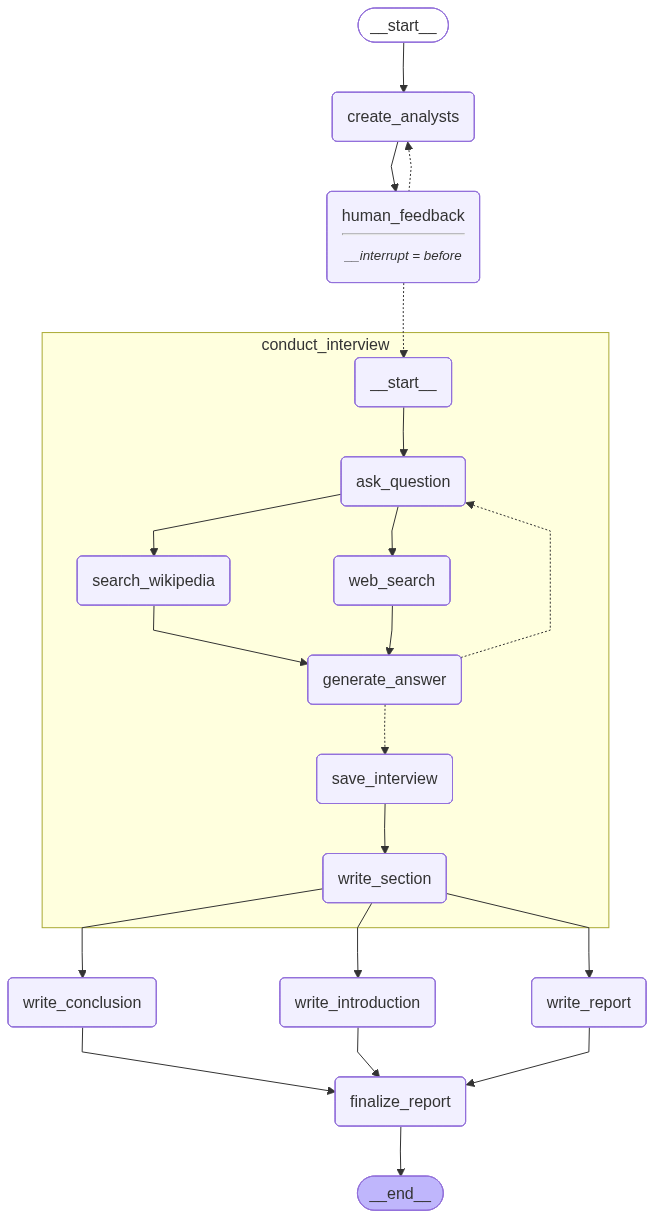

In [44]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

Let's ask an open-ended question about LangGraph.

In [45]:
# Inputs
max_analysts = 3
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,
                           "max_analysts":max_analysts},
                          thread,
                          stream_mode="values"):

    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Dr. Emily Carter
Affiliation: Tech Innovations Inc.
Role: AI Framework Specialist
Description: Dr. Carter focuses on the technical advantages of LangGraph, analyzing its architecture and performance metrics compared to other frameworks. She is particularly interested in how LangGraph can enhance the efficiency of AI agents in real-world applications.
--------------------------------------------------
Name: Mr. James Liu
Affiliation: Future of Work Institute
Role: Workplace Integration Analyst
Description: Mr. Liu examines the implications of adopting LangGraph in workplace settings. He explores how this framework can improve collaboration among teams and streamline workflows, ultimately enhancing productivity and employee satisfaction.
--------------------------------------------------
Name: Ms. Sarah Thompson
Affiliation: Data-Driven Insights LLC
Role: Data Analytics Expert
Description: Ms. Thompson investigates the data management capabilities of LangGraph, focusing on its abil

In [46]:
state = graph.get_state(thread)
state.next

('human_feedback',)

In [47]:
# If we are satisfied, then we simply supply no feedback
further_feedback = None
graph.update_state(
    thread,
    { "human_analyst_feedback": further_feedback}, as_node="human_feedback"
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0e8aad-1032-639b-8002-5be5894a5024'}}

In [48]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
write_conclusion
--Node--
write_introduction
--Node--
write_report
--Node--
finalize_report


In [49]:
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')

In [50]:
Markdown(report)

# Unlocking the Future of AI Development with LangGraph

## Introduction

LangGraph is revolutionizing the landscape of AI agent development by offering a transformative framework that enhances efficiency and effectiveness. This report explores the unique advantages of LangGraph, including its ability to create complex decision trees with real conditional branching, which simplifies the development of sophisticated agent behaviors. We delve into its rapid adoption by industry leaders like LinkedIn and Uber, highlighting its practical applications in real-world scenarios. Additionally, we examine how LangGraph enhances workplace collaboration and streamlines workflows, ultimately empowering organizations to make data-driven decisions. Join us as we uncover the potential of LangGraph to reshape the future of intelligent systems.

---


LangGraph has emerged as a transformative framework for developing AI agents, offering unique advantages that set it apart from traditional frameworks. As the demand for intelligent, autonomous systems grows, LangGraph provides a structured approach that enhances the efficiency and effectiveness of AI applications. Notably, it allows developers to create decision trees with real conditional branching, enabling complex agent behaviors to be constructed visually rather than through linear coding. This flexibility is particularly beneficial for applications requiring human-in-the-loop scenarios, where agents can be interrupted and resumed seamlessly, enhancing user interaction and operational efficiency [1][2].

The rapid adoption of LangGraph by major companies like LinkedIn and Uber underscores its practical utility in real-world applications. The framework's ability to integrate advanced natural language processing (NLP) techniques allows AI agents to understand and generate human language effectively, paving the way for innovative applications across various industries [3][4]. Furthermore, LangGraph's architecture supports the streaming of outputs, including LLM tokens, which is crucial for developing user interfaces that present reasoning steps and explanations clearly [5].

In workplace settings, LangGraph presents a transformative opportunity for enhancing collaboration and streamlining workflows among teams. It allows organizations to create intelligent workflows that can adapt to complex business processes, managing conditional branching and cyclical processing essential for developing sophisticated AI agents capable of executing tasks autonomously. Organizations utilizing LangGraph report significant productivity gains, with tasks completed by AI agents using this framework typically 126% faster than those performed manually, particularly in customer service operations [1][2]. This efficiency is attributed to LangGraph's visual workflow management, which simplifies the development process [3][4].

Moreover, LangGraph's integration capabilities allow it to work seamlessly with various tools and services, making it versatile for different applications, from document approval workflows to customer support systems [5][6]. The framework encourages collaboration among AI agents, mimicking a team dynamic that enhances overall productivity [7]. However, it is important to assess the specific needs of a project before implementation, as LangGraph may introduce unnecessary complexity for simpler applications [8].

In the realm of data management and analytics, LangGraph facilitates the development of stateful, multi-agent applications powered by large language models (LLMs). It leverages the concept of the Semantic Web to provide a graph-based structure that allows developers to create complex workflows that can adapt and respond to user interactions in real-time. LangGraph's ability to handle large datasets while maintaining context enables sophisticated decision-making processes, making it a valuable tool for organizations looking to harness the power of AI in their operations [1][2].

The integration of AI agents into business processes is reshaping how companies approach automation and data synthesis. LangGraph's capabilities allow for the creation of reliable, production-ready systems that can automate support workflows and enhance decision-making through real-time data analysis [6]. This shift towards agentic automation signifies a transformative step in leveraging AI for improved business outcomes.

In summary, LangGraph stands out due to its unique capabilities, rapid adoption by industry leaders, and the potential to revolutionize AI agent development. Its innovative approach not only simplifies the development process but also empowers businesses to make data-driven decisions more effectively, significantly improving team collaboration and workflow efficiency.


---

## Conclusion

LangGraph represents a significant advancement in the development of AI agents, offering a unique framework that enhances efficiency, collaboration, and data-driven decision-making. Its ability to create complex decision trees with real conditional branching allows for sophisticated agent behaviors, making it ideal for dynamic environments. The framework's rapid adoption by industry leaders like LinkedIn and Uber highlights its practical utility and effectiveness in real-world applications. Furthermore, LangGraph's modular design and seamless integration capabilities empower organizations to streamline workflows and improve productivity. As businesses increasingly leverage AI, LangGraph is poised to play a pivotal role in shaping the future of intelligent systems.

## Sources
[1] https://blog.langchain.com/building-langgraph/  
[2] https://community.latenode.com/t/what-are-the-main-advantages-of-choosing-langgraph-for-ai-agent-development/31000  
[3] https://medium.com/@hao.l/why-langgraph-stands-out-as-an-exceptional-agent-framework-44806d969cc6  
[4] https://www.projectpro.io/article/langgraph-projects-and-examples/1124  
[5] https://www.rapidinnovation.io/post/ai-agents-in-langgraph/  
[6] https://www.tribe.ai/applied-ai/unlocking-the-magic-of-agentic-frameworks-building-collaborative-ai-teams-with-langgraph  
[7] https://en.wikipedia.org/wiki/Applications_of_artificial_intelligence  
[8] https://en.wikipedia.org/wiki/Semantic_Web  
[9] https://en.wikipedia.org/wiki/Deep_lear